# Procedure for estimating noise parameters

In [1]:
from __future__ import annotations

import numdifftools as nd
import numpy as np

from numpy.typing import ArrayLike
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.figure import figaspect
from scipy.optimize import approx_fprime
from numpy.random import default_rng

import thztools as thz
from thztools import tdnll

## Simulate measurements
Simulate a set of `m` waveforms, each sampled at `n` time points, with noise parameters
`sigma_alpha`, `sigma_beta`, and `sigma_tau`, and store them in an array `x`. Note that
`x` stores the waveforms in row orientation, with shape `(m, n)`, because NumPy
broadcasting rules and FFT functions are simpler for arrays that are row-oriented.
Measurement waveforms are typically loaded from data files in column orientation,
however, so the `tdnoisefit` function assumes that the data array is column-oriented—this
may be worth changing in a future version.

In [2]:
rng = np.random.default_rng(0)
n = 256
m = 64
ts = 0.05
t = np.arange(n) * ts
mu, _ = thz.thzgen(n, ts=ts, t0=n * ts / 3)
sigma = np.array([1e-5, 1e-2, 1e-3])
noise = thz.noiseamp(sigma, mu, ts) * rng.standard_normal((m, n))
x = np.array(mu + noise)
a = np.ones(m)
eta = np.zeros(m)

## Fit for the noise parameters

Set the initial guesses `a0` and `eta0` for the amplitudes and delays, respectively, and
estimate the noise parameters from the simulated measurements. Note that we must take the
transpose of `x`, to convert it from row-orientation to column-orientation.

In [3]:
result = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=mu,
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)

In [4]:
result_all_free = thz.tdnoisefit(x.T, ts=ts)

In [5]:
sigma_out = np.sqrt(result_all_free[0]["var"])
for val_in, val_out in zip(sigma, sigma_out):
    print(f"Input: {val_in:6.4g}\t Output: {val_out:6.4g}")

Input:  1e-05	 Output: 5.413e-05
Input:   0.01	 Output: 0.005961
Input:  0.001	 Output: 0.004566


## Plot the data

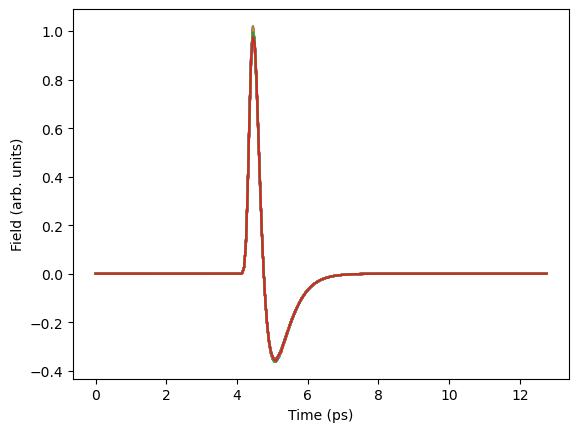

In [6]:
_, ax = plt.subplots()
ax.plot(t, x.T)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Field (arb. units)')
plt.show()

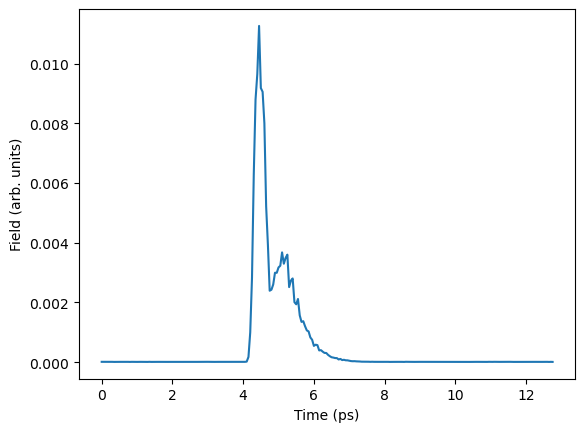

In [7]:
_, ax = plt.subplots()
ax.plot(t, np.std(x, axis=0).T)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Field (arb. units)')
plt.show()

## Consider alternative method
Try alternating between minimizing the least-squares portion of the cost function for fixed $\sigma$ and minimizing the log-likelihood as a function of $\sigma$ while holding all other parameters fixed.

## Check gradient calculation in tdnll

In [8]:
logv = np.log(sigma**2)
val, grad_mu_tdnll = tdnll(
    x,
    mu,
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)

In [9]:
grad_mu_fprime = approx_fprime(
    mu,
    lambda _mu: tdnll(
        x,
        _mu,
        logv,
        a,
        eta,
        ts,
        fix_logv=True,
        fix_mu=True,
        fix_a=True,
        fix_eta=True,
    )[0],
    epsilon=1e-10,
)

In [10]:
grad_mu_tdnll

array([ 1.55708929e+06,  4.88661781e+05,  5.87287566e+05, -5.63994582e+05,
       -9.48484397e+05, -1.11423785e+06, -1.54137805e+06, -1.14154956e+06,
        2.91283579e+05, -3.42848351e+05,  8.32715288e+05, -5.84136730e+05,
       -1.09405807e+06, -5.36153270e+05, -1.79398811e+06, -1.65456739e+05,
        5.27988257e+05, -3.44634231e+04, -8.89878954e+05,  5.08611553e+05,
        5.55984833e+05, -8.85097218e+05, -1.38645450e+06,  2.99163478e+05,
       -1.41676123e+06,  2.08965975e+06,  1.40533874e+05,  1.05374326e+04,
       -6.32116569e+05, -3.35616675e+05,  6.08722390e+04, -7.67999494e+05,
        4.39766211e+05,  1.00697518e+06, -2.52042934e+05,  1.03071190e+05,
       -8.02639104e+05, -1.05235645e+06, -6.84200619e+05,  1.21247978e+06,
       -1.62849938e+05,  1.70708903e+05,  1.28508579e+06, -7.83626421e+05,
       -1.53949515e+06,  3.09969803e+05,  4.61465713e+04,  3.34672875e+05,
       -2.25447519e+05, -1.26245213e+06,  7.42530653e+04,  2.93740196e+04,
       -6.34052581e+05,  

In [11]:
grad_mu_fprime

array([ 1.55712129e+06,  4.88694641e+05,  5.87318500e+05, -5.63966169e+05,
       -9.48453962e+05, -1.11420726e+06, -1.54134672e+06, -1.14151539e+06,
        2.91314791e+05, -3.42817220e+05,  8.32749065e+05, -5.84102818e+05,
       -1.09402579e+06, -5.36123698e+05, -1.79395574e+06, -1.65425881e+05,
        5.28019445e+05, -3.44309956e+04, -8.89845833e+05,  5.08642697e+05,
        5.56017621e+05, -8.85063200e+05, -1.38642587e+06,  2.99195235e+05,
       -1.41673052e+06,  2.08968937e+06,  1.40568591e+05,  1.05687650e+04,
       -6.32086594e+05, -3.35586374e+05,  6.09035487e+04, -7.67966849e+05,
        4.39799333e+05,  1.00700650e+06, -2.52009777e+05,  1.03100610e+05,
       -8.02603900e+05, -1.05232350e+06, -6.84169936e+05,  1.21251156e+06,
       -1.62818178e+05,  1.70740532e+05,  1.28511630e+06, -7.83592986e+05,
       -1.53946370e+06,  3.09998286e+05,  4.61778836e+04,  3.34702490e+05,
       -2.25414697e+05, -1.26242405e+06,  7.42840348e+04,  2.94009806e+04,
       -6.34020253e+05,  

In [12]:
def tdnll_mu(_mu):
    return tdnll(
        x,
        _mu,
        logv,
        a,
        eta,
        ts,
        fix_logv=True,
        fix_mu=True,
        fix_a=True,
        fix_eta=True,
    )[0]

In [13]:
grad_mu_nd = nd.Gradient(tdnll_mu, step=1e-10)(mu)

In [14]:
grad_mu_nd

array([ 1.55708929e+06,  4.88660403e+05,  5.87288475e+05, -5.63994353e+05,
       -9.48485753e+05, -1.11424049e+06, -1.54137919e+06, -1.14154862e+06,
        2.91282607e+05, -3.42848479e+05,  8.32714217e+05, -5.84137549e+05,
       -1.09405815e+06, -5.36151739e+05, -1.79398921e+06, -1.65458318e+05,
        5.27987533e+05, -3.44621338e+04, -8.89879374e+05,  5.08611514e+05,
        5.55986434e+05, -8.85095141e+05, -1.38645733e+06,  2.99163487e+05,
       -1.41676300e+06,  2.08965776e+06,  1.40534382e+05,  1.05376230e+04,
       -6.32116664e+05, -3.35616177e+05,  6.08700743e+04, -7.67999382e+05,
        4.39766554e+05,  1.00697251e+06, -2.52041916e+05,  1.03070334e+05,
       -8.02637011e+05, -1.05235775e+06, -6.84201603e+05,  1.21248032e+06,
       -1.62850033e+05,  1.70708649e+05,  1.28508637e+06, -7.83626536e+05,
       -1.53949617e+06,  3.09967992e+05,  4.61445559e+04,  3.34670448e+05,
       -2.25447129e+05, -1.26245421e+06,  7.42508503e+04,  2.93727474e+04,
       -6.34053815e+05,  

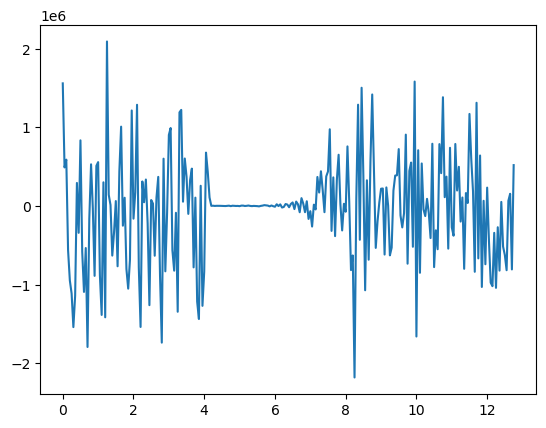

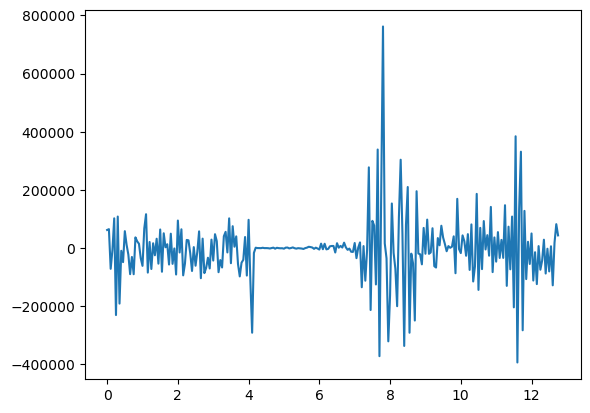

In [15]:
plt.plot(t, grad_mu_nd)
plt.show()
plt.plot(t, nd.Gradient(tdnll_mu, step=1e-10)(result[0]["mu"]))
plt.show()

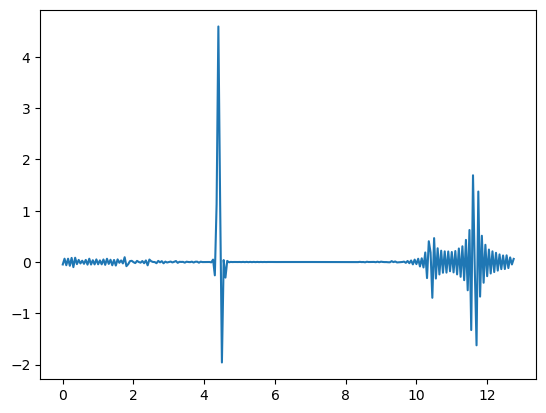

In [30]:
last_result = result
cur_result = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=last_result[0]["mu"],
    a0=a,
    eta0=eta,
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)

i = 0
while (
    (cur_result[1] < last_result[1])
    and cur_result[2]["success"]
    and cur_result[2]["nit"] > 0
    and i < 100
):
    i += 1
    last_result = cur_result
    cur_result = thz.tdnoisefit(
        x.T,
        v0=sigma**2,
        mu0=last_result[0]["mu"],
        a0=a,
        eta0=eta,
        ts=ts,
        fix_v=True,
        fix_mu=False,
        fix_a=True,
        fix_eta=True,
    )

_, grad_mu = tdnll(
    x,
    cur_result[0]["mu"],
    logv,
    a,
    eta,
    ts,
    fix_logv=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)
plt.plot(t, grad_mu)
plt.show()

In [31]:
print(f"{i=}")

i=1029652


In [32]:
print((cur_result[1] < last_result[1]))
print(cur_result[2]["success"])
print(cur_result[2]["nit"])

False
True
1


In [33]:
print(cur_result[1])
print(last_result[1])

-147726.16305170205
-147726.16305170205


## Iterate fit to see if it improves accuracy

In [34]:
result_eta_free = thz.tdnoisefit(
    x.T, ts=ts, fix_v=True, fix_mu=True, fix_a=True, fix_eta=False
)

In [35]:
result_mu_free = thz.tdnoisefit(
    x.T,
    eta0=result_eta_free[0]["eta"],
    ts=ts,
    fix_v=True,
    fix_mu=False,
    fix_a=True,
    fix_eta=True,
)

In [36]:
result_a_free = thz.tdnoisefit(
    x.T,
    mu0=result_mu_free[0]["mu"],
    eta0=result_eta_free[0]["eta"],
    ts=ts,
    fix_v=True,
    fix_mu=True,
    fix_a=False,
    fix_eta=True,
)

In [37]:
result_v_free = thz.tdnoisefit(
    x.T,
    mu0=result_mu_free[0]["mu"],
    a0=result_a_free[0]["a"],
    eta0=result_eta_free[0]["eta"],
    fix_v=False,
    fix_mu=True,
    fix_a=True,
    fix_eta=True,
)

In [38]:
result_all = thz.tdnoisefit(
    x.T,
    v0=result_v_free[0]["var"],
    mu0=result_mu_free[0]["mu"],
    a0=result_a_free[0]["a"],
    eta0=result_eta_free[0]["eta"],
    fix_v=False,
    fix_mu=False,
    fix_a=False,
    fix_eta=False,
)

In [42]:
var_out = result_all[0]["var"] * m / (m - 1)
var_err = result_all[2]["err"]["var"] * m / (m - 1)
for val_in, val_out, err in zip(sigma**2, var_out, var_err):
    print(f"Input: {val_in:6.4g}\t Output: {val_out:6.4g} ± {err:6.4g}")

Input:  1e-10	 Output: 1.187e-10 ± 1.332e-10
Input: 0.0001	 Output: 8.262e-05 ± 8.291e-05
Input:  1e-06	 Output: 0.001877 ± 0.001902


In [44]:
result_true_init = thz.tdnoisefit(
    x.T,
    v0=sigma**2,
    mu0=mu,
    a0=a,
    eta0=eta,
    fix_v=False,
    fix_mu=False,
    fix_a=False,
    fix_eta=False,
)

In [45]:
var_out = result_true_init[0]["var"] * m / (m - 1)
var_err = result_true_init[2]["err"]["var"] * m / (m - 1)
for val_in, val_out, err in zip(sigma**2, var_out, var_err):
    print(f"Input: {val_in:6.4g}\t Output: {val_out:6.4g} ± {err:6.4g}")

Input:  1e-10	 Output: 1.016e-10 ± 1.016e-10
Input: 0.0001	 Output: 0.0001018 ± 0.0001024
Input:  1e-06	 Output: 1.016e-06 ± 1.017e-06
